<h1>Installing and importing the libraries</h1>

In [1]:
import os
import cv2
import pandas as pd
import matplotlib as mat
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from skimage.io import imread
%matplotlib inline
pd.options.display.max_colwidth = 100

import random

from numpy.random import seed
seed(50)

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, Concatenate, Dense, Flatten, Add, Dropout
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

<h1>The Chest X-ray Dataset</h1>

In [2]:
#Defining the Directory Paths to the dataset
chest_xray_dir = "C:/Users/Zhong Da Goh/Desktop/CM3070/TB_Chest_Radiography_Database"
normal_xray_dir = os.path.join(chest_xray_dir,'Normal')
tb_xray_dir = os.path.join(chest_xray_dir,'Tuberculosis')

#Listing the PNG files 
normal_images = [file for file in os.listdir(normal_xray_dir)]
tb_images = [file for file in os.listdir(tb_xray_dir)]

# Count the number of image files in each directory
num_normal_images = len(normal_images)
num_tb_images = len(tb_images)

print(f"Normal Xray Set has: {num_normal_images} images")
print(f"Tuberculosis Xray Set has: {num_tb_images} images")

Normal Xray Set has: 3500 images
Tuberculosis Xray Set has: 700 images


In [3]:
img_size = (244, 244)  # Target size to resize images
num_images = 5  # Number of images to randomly select and display

# Select random images from the directories
random_normal_images = random.sample(normal_images, len(normal_images))  # Randomly select images from 'Normal' directory
random_tb_images = random.sample(tb_images, len(tb_images))              # Randomly select images from 'Tuberculosis' directory

# Load and resizes images function
def load_and_resize_image(directory, file, size):
    img_path = os.path.join(directory, file)    # Construct the full path to the image file
    img = cv2.imread(img_path)                  # Read the image using OpenCV
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert the image from BGR (OpenCV default) to RGB format
    img = cv2.resize(img, size)                 # Resize the image to the specified size
    img = img / 255.0                           # Normalize pixel values to the range [0, 1]
    return img                                  # Returns the processed image

# Load images from both directories and resize them using the defined function
normal_imgs = [load_and_resize_image(normal_xray_dir, file, img_size) for file in random_normal_images]  # Load and resize images from 'Normal' directory
tb_imgs = [load_and_resize_image(tb_xray_dir, file, img_size) for file in random_tb_images]  # Load and resize images from 'Tuberculosis' directory

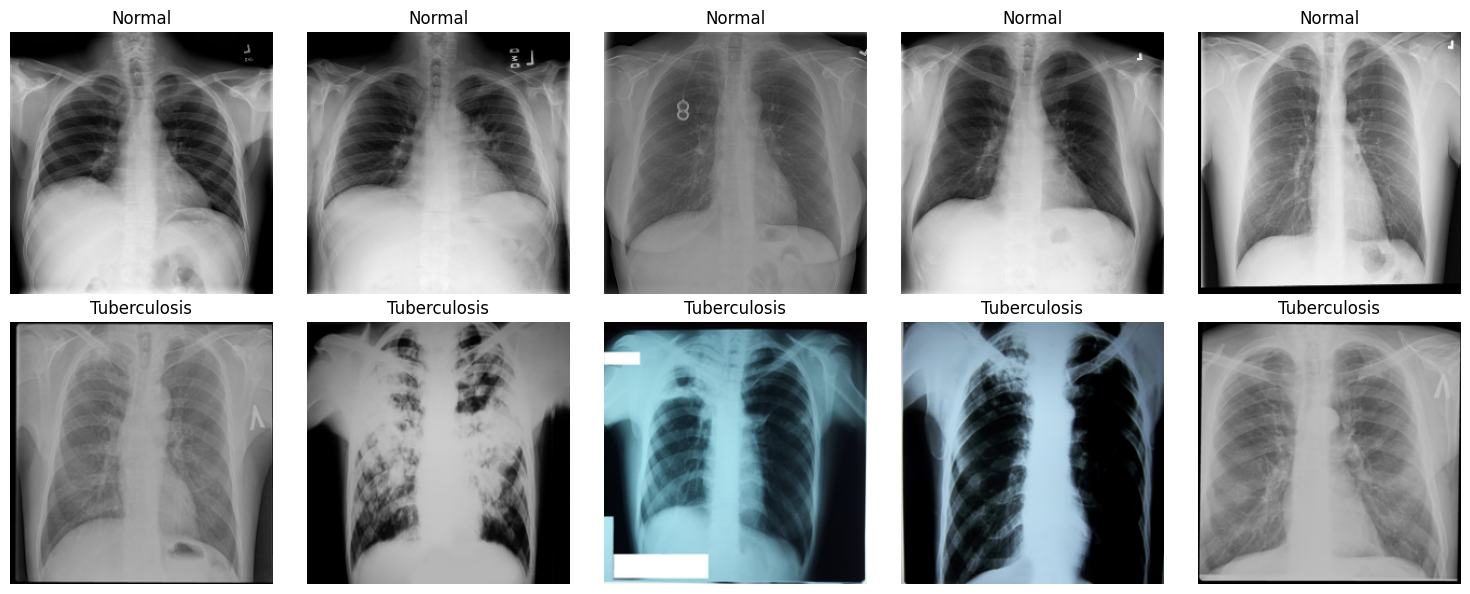

In [4]:
# Create a 2x5 grid for displaying images
fig, axes = plt.subplots(2, num_images, figsize=(15, 6)) 

# Display images from the 'Normal' category
for i in range(num_images):
    axes[0, i].imshow(normal_imgs[i])  # Display the i-th image from the 'Normal' images list
    axes[0, i].axis('off')             # Hide the axis for a cleaner look
    axes[0, i].set_title('Normal')     # Set the title for each subplot to 'Normal'

# Display images from the 'Tuberculosis' category
for i in range(num_images):
    axes[1, i].imshow(tb_imgs[i])         # Display the i-th image from the 'Tuberculosis' images list
    axes[1, i].axis('off')                # Hide the axis for a cleaner look
    axes[1, i].set_title('Tuberculosis')  # Set the title for each subplot to 'Tuberculosis'

plt.tight_layout()  # Adjust subplot parameters to give specified padding
plt.show()  # Display the plot with all images

<h1>Stratified Train-Test Split (Evaluation Protocol)</h1>

In [5]:
# Combine the lists of all images and create labels
combined_images = normal_images + tb_images
labels = [0] * len(normal_images) + [1] * len(tb_images)  # 0 for Normal, 1 for Tuberculosis

# Perform stratified train-test split
train_images, test_images, train_labels, test_labels = train_test_split(combined_images, labels, 
                                                                        test_size=0.2,     #20% of the data will be used as the test set
                                                                        stratify=labels, 
                                                                        random_state=50)   #For reproducibility

# Print the sizes of the training and test sets
print(f"Training set: {len(train_images)} images")
print(f"Test set: {len(test_images)} images")

Training set: 3360 images
Test set: 840 images


In [6]:
# Load and preprocess training images
X_train = np.array([load_and_resize_image(normal_xray_dir if label == 0 else tb_xray_dir, img, img_size) 
                    for img, label in zip(train_images, train_labels)])
y_train = np.array(train_labels)

# Load and preprocess testing images
X_test = np.array([load_and_resize_image(normal_xray_dir if label == 0 else tb_xray_dir, img, img_size) 
                   for img, label in zip(test_images, test_labels)])
y_test = np.array(test_labels)

# Print the shapes of the training and test sets
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (3360, 244, 244, 3)
y_train shape: (3360,)
X_test shape: (840, 244, 244, 3)
y_test shape: (840,)


<h2>Augmenting the training data</h2>

In [7]:
img_width, img_height = 244, 244  # Image dimensions
batch_size = 32
epochs = 10
random_seed = 50

# Create ImageDataGenerator instances
train_datagen = ImageDataGenerator(
    rescale=1./255,                # Normalize pixel values to the range [0, 1]
    rotation_range=10,             # Rotate by a certain degree range to simulate different angles at which X-rays might be taken
    brightness_range=[0.8, 1.2],   # Adjust brightness 
    zoom_range=0.1,                # Apply random zoom transformations
    width_shift_range=0.1,         # Apply random horizontal shifts
    height_shift_range=0.1,        # Apply random vertical shifts
    horizontal_flip=True,          # Flip images horizontally
    validation_split=0.2  # Splitting training data into training and validation sets
)

# Generate batches of augmented data
train_dataset = train_datagen.flow_from_directory(
    chest_xray_dir,
    target_size=(img_width, img_height),    # Resize images to a specific size
    batch_size=batch_size,                  # Batch size for training
    class_mode='binary',                    # Binary classification (two classes)
    subset='training',                      # Specify training data
    shuffle=True,                           # Shuffle the data
    seed=random_seed                        # Random seed for reproducibility
)

validation_dataset = train_datagen.flow_from_directory(
    chest_xray_dir,
    target_size=(img_width, img_height),   # Resize images to a specific size
    batch_size=batch_size,                 # Batch size for validation
    class_mode='binary',                   # Binary classification (two classes)
    subset='validation',                   # Specify validation data
    shuffle=False,                         # Do not shuffle the data for validation
    seed=random_seed                       # Random seed for reproducibility
)

Found 3360 images belonging to 2 classes.
Found 840 images belonging to 2 classes.


<h1>Visualising the augmented training data</h1>

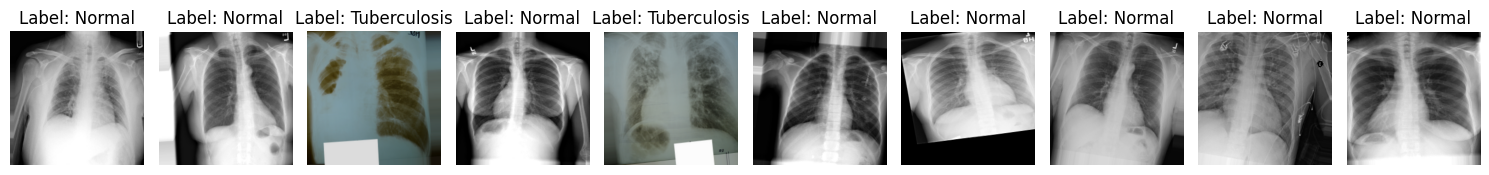

In [12]:
# Get a batch of images and labels from the training dataset
images, labels = next(train_dataset) 

# Define the number of images to display
num_images_to_display = 10  

plt.figure(figsize=(15, 10))

# Plot images
for i in range(num_images_to_display):
    plt.subplot(1, num_images_to_display, i + 1)  # Create subplots
    plt.imshow(images[i], cmap='gray')  # Display the image in grayscale 
    plt.title(f"Label: {'Normal' if labels[i] == 0 else 'Tuberculosis'}")  # Display the label
    plt.axis('off')  # Hide axis

plt.tight_layout()
plt.show()

<h1>Developing a Convolutional Neural Network (CNN) Model</h1>

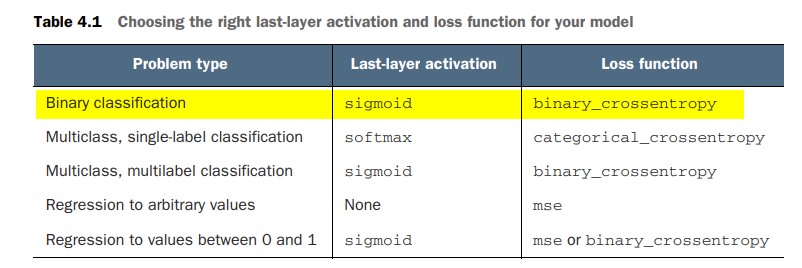

<h2>Callbacks for training models</h2>

In [16]:
# Define an EarlyStopping callback
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',            # Metric to monitor for early stopping (validation loss)
    patience=5,                    # Number of epochs with no improvement before stopping
    min_delta=1e-7,                # Minimum change in monitored metric to be considered an improvement
    verbose=1,                     # Verbosity level (1 for updates)
    restore_best_weights=True,     # Restore model weights to the best state when stopped
)

# Define a ReduceLROnPlateau callback
reduceLR = callbacks.ReduceLROnPlateau(
    monitor='val_loss',            # Metric to monitor for learning rate reduction (validation loss)
    factor=0.5,                    # Factor by which the learning rate will be reduced (e.g., 0.2 means lr *= 0.2)
    patience=2,                    # Number of epochs with no improvement before reducing the learning rate
    min_delta=1e-6,                # Minimum change in monitored metric to trigger a reduction
    cooldown=0,                    # Number of epochs to wait after a reduction before resuming normal operation
    verbose=1                      # Verbosity level (1 for updates)
)

<h1>CNN Model</h1>

In [17]:
def CNNModel():
  # Input layer
  inputs = Input(shape=(img_height, img_width, 3))

  # Convolutional layers
  x = Conv2D(32, (3, 3), activation='relu')(inputs)
  x = MaxPooling2D((2, 2))(x)
  x = Conv2D(64, (3, 3), activation='relu')(x)
  x = MaxPooling2D((2, 2))(x)

  # Flatten layer
  x = Flatten()(x)

  # Fully connected layers
  x = Dense(64, activation='relu')(x)
  output = Dense(1, activation='sigmoid')(x) 

  # Create model
  model = Model(inputs=[inputs], outputs=output, name='CNN_Model')

  return model

# Clear the Keras session to release resources
keras.backend.clear_session()

# Create a CNN model using the 'CNNModel' function
CNNModel = CNNModel()

# Compile the CNN model with specified loss, optimizer, and metrics
CNNModel.compile(
    loss='binary_crossentropy',  # Binary cross-entropy loss for binary classification
    optimizer=keras.optimizers.Adam(),  # Adam optimizer with a custom learning rate
    metrics=['binary_accuracy']  # Metric to monitor during training (binary accuracy)
)

# Display a summary of the model architecture
CNNModel.summary()

Model: "CNN_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 244, 244, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 242, 242, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 121, 121, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 119, 119, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 59, 59, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 222784)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │      14,258,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,277,697 (54.47 MB)

 Trainable params: 14,277,697 (54.47 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Train the model
CNNModel_hist = CNNModel.fit(train_dataset,
          validation_data=validation_dataset,
          epochs=10,
          batch_size=batch_size,
          callbacks=[early_stopping,reduceLR]  #  Callbacks for early stopping and learning rate reduction
)

Epoch 1/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 87s 790ms/step - binary_accuracy: 0.7432 - loss: 0.9890 - val_binary_accuracy: 0.8595 - val_loss: 0.4077 - learning_rate: 0.0010
Epoch 2/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 88s 806ms/step - binary_accuracy: 0.9310 - loss: 0.2338 - val_binary_accuracy: 0.8738 - val_loss: 0.2489 - learning_rate: 0.0010
Epoch 3/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 88s 806ms/step - binary_accuracy: 0.9372 - loss: 0.1767 - val_binary_accuracy: 0.9167 - val_loss: 0.1808 - learning_rate: 0.0010
Epoch 4/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 88s 802ms/step - binary_accuracy: 0.9460 - loss: 0.1554 - val_binary_accuracy: 0.9083 - val_loss: 0.1742 - learning_rate: 0.0010
Epoch 5/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 87s 797ms/step - binary_accuracy: 0.9505 - loss: 0.1404 - val_binary_accuracy: 0.9369 - val_loss: 0.1592 - learning_rate: 0.0010
Epoch 6/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 88s 802ms/step - binary_accuracy: 0.9561 - loss: 0.1204 - val_binary_accuracy: 0.9452 - val_loss: 0.1522 - learning

<h1>Visualisation of the CNN Model's training</h1>

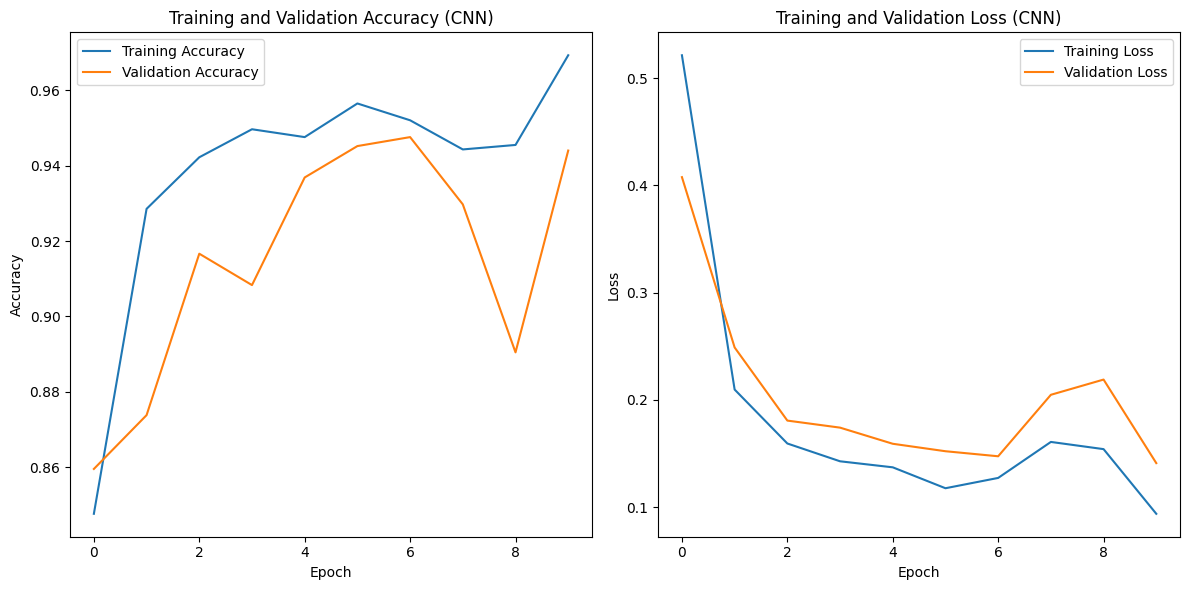

In [19]:
# Plotting the results of model training
plt.figure(figsize=(12, 6))

# Plot accuracy curve
plt.subplot(1, 2, 1)
plt.plot(CNNModel_hist.history['binary_accuracy'], label='Training Accuracy')
plt.plot(CNNModel_hist.history['val_binary_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy (CNN)')
plt.legend()

# Plot loss curve
plt.subplot(1, 2, 2)
plt.plot(CNNModel_hist.history['loss'], label='Training Loss')
plt.plot(CNNModel_hist.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (CNN)')
plt.legend()

plt.tight_layout()
plt.show()

<h1>Evaluation of the CNN Model</h1>

In [20]:
# Evaluate the model on the validation set
val_loss, val_acc = CNNModel.evaluate(validation_dataset, verbose=2)
print(f'Validation accuracy: {val_acc}, Validation loss: {val_loss}')

# Evaluate the model on the test set
test_loss, test_acc = CNNModel.evaluate(X_test, y_test, verbose=2)
print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')

27/27 - 13s - 479ms/step - binary_accuracy: 0.9524 - loss: 0.1215
Validation accuracy: 0.9523809552192688, Validation loss: 0.12148359417915344
27/27 - 2s - 84ms/step - binary_accuracy: 0.9750 - loss: 0.0674
Test accuracy: 0.9750000238418579, Test loss: 0.06739521771669388


In [21]:
# Evaluate the model on the test set and obtain predictions
test_predictionsCNN = CNNModel.predict(X_test, batch_size=batch_size, verbose=1)

# Convert probability scores to binary predictions (0 or 1)
testProbability_predictionsCNN = (test_predictionsCNN > 0.5).astype(int)

# Generate a classification report for precision, recall, and F1-score
testClassificationReport_CNN = classification_report(y_test, testProbability_predictionsCNN, output_dict=True)

# Print the test accuracy, precision, recall, and F1-score
print('Test Accuracy:', testClassificationReport_CNN['accuracy'])
print('Test Precision (Overall):', testClassificationReport_CNN['macro avg']['precision'])
print('Test Recall (Overall):', testClassificationReport_CNN['macro avg']['recall'])
print('Test F1 Score (Overall):', testClassificationReport_CNN['macro avg']['f1-score'])

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step
Test Accuracy: 0.975
Test Precision (Overall): 0.9786202673742219
Test Recall (Overall): 0.9307142857142857
Test F1 Score (Overall): 0.9526660244558873


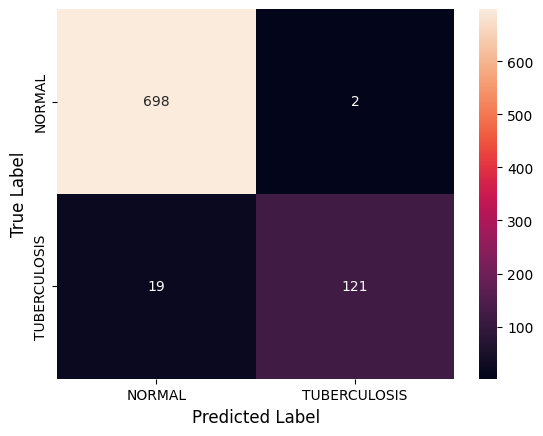

In [22]:
# Calculate the confusion matrix between true labels and predicted labels
confusionMatrix_CNN = metrics.confusion_matrix(y_test, testProbability_predictionsCNN)

# Create a heatmap of the confusion matrix with annotations
sns.heatmap(confusionMatrix_CNN, annot=True, fmt="d", xticklabels=['NORMAL', 'TUBERCULOSIS'], yticklabels=['NORMAL', 'TUBERCULOSIS'])

# Set the x-axis label
plt.xlabel("Predicted Label", fontsize=12)

# Set the y-axis label
plt.ylabel("True Label", fontsize=12)

# Display the heatmap
plt.show()

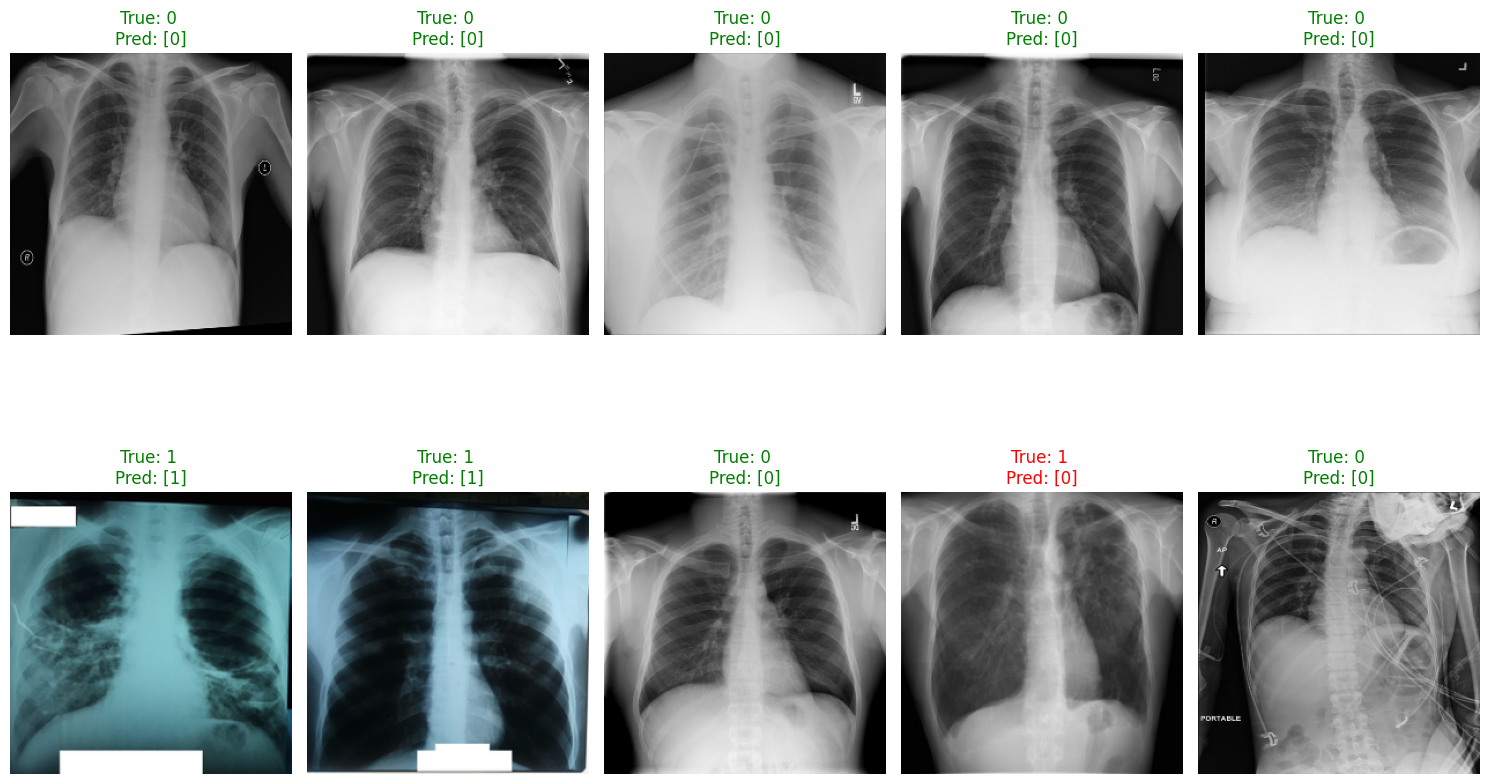

In [37]:
# Select a random sample of images to display
num_images_to_display = 10  
indices = np.random.choice(len(X_test), num_images_to_display, replace=False)  # Randomly select indices of images from the test set

plt.figure(figsize=(15, 10))

# Loop through the randomly selected images and display them
for i, idx in enumerate(indices):
    plt.subplot(2, 5, i + 1)                               # Create a subplot in a 2x5 grid
    plt.imshow(X_test[idx], cmap='gray')                   # Display the image in grayscale
    true_label = y_test[idx]                               # Get the true label of the current image
    predicted_label = testProbability_predictionsCNN[idx]  # Get the predicted label from the model
    
    # Set the title color: green if the prediction is correct, red if incorrect
    color = 'green' if true_label == predicted_label else 'red'
    
    # Display the true and predicted labels with color coding
    plt.title(f"True: {true_label} \nPred: {predicted_label}", color=color)
    plt.axis('off')

plt.tight_layout()
plt.show() 

<h1>ResNet50 Model</h1>

In [49]:
def convolutionalBlock(x, filters, stage, block, stride=2):
    """
    Implementation of the convolutional block
    Arguments:
    x -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    stride -- Integer, specifying the stride to be used
    Returns:
    x -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """

    convolutionalName = 'convolutionalStage' + str(stage) + 'Block' + str(block) 
    batchNormName = 'blockStage' + str(stage) + 'Block' + str(block) 

    f1, f2, f3 = filters

    inputCopy = x

    # First component of main path
    x = Conv2D(f1, (1, 1), strides=(stride, stride), name=convolutionalName + '2a')(x)
    x = BatchNormalization(axis=3, name=batchNormName + '2a')(x)
    x = Activation('relu')(x)

    # Second component of main path
    x = Conv2D(f2, (3, 3), strides=(1, 1), padding='same', name=convolutionalName + '2b')(x)
    x = BatchNormalization(axis=3, name=batchNormName + '2b')(x)
    x = Activation('relu')(x)

    # Third component of main path
    x = Conv2D(f3, (1, 1), strides=(1, 1), name=convolutionalName + '2c')(x)
    x = BatchNormalization(axis=3, name=batchNormName + '2c')(x)

    # Shortcut path
    # Conv2D to make shape the same size
    inputCopy = Conv2D(f3, (1, 1), strides=(stride, stride), name=convolutionalName + '1')(inputCopy)
    inputCopy = BatchNormalization(axis=3, name=batchNormName + '1')(inputCopy)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    x = Add()([x, inputCopy])
    x = Activation('relu')(x)

    return x

def identityBlock(x, filters, stage, block):
    """
    Implementation of the identity block
    Arguments:
    x -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    Returns:
    x -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """

    convolutionalName = 'convolutionalStage' + str(stage) + 'Block' + str(block)
    batchNormName = 'blockStage' + str(stage) + 'Block' + str(block)

    f1, f2, f3 = filters

    inputCopy = x

    # First component of main path
    x = Conv2D(filters=f1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=convolutionalName + '2a')(x)
    x = BatchNormalization(axis=3, name=batchNormName + '2a')(x)
    x = Activation('relu')(x)

    # Second component of main path
    x = Conv2D(filters=f2, kernel_size=(3, 3), strides=(1, 1), padding='same', name=convolutionalName + '2b')(x)
    x = BatchNormalization(axis=3, name=batchNormName + '2b')(x)
    x = Activation('relu')(x)

    # Third component of main path
    x = Conv2D(filters=f3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=convolutionalName + '2c')(x)
    x = BatchNormalization(axis=3, name=batchNormName + '2c')(x)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    x = Add()([x, inputCopy])
    x = Activation('relu')(x)

    return x

def resnet50Model():
  inputs = Input(shape=(img_height, img_width, 3), name='input')

  # conv1 - Stage 1, Block 1
  x = Conv2D(filters=64, kernel_size=7, padding='same', strides=2, name="res1")(inputs)
  x = BatchNormalization(axis=3, name="bn1")(x)
  x = Activation('relu')(x)
  x = MaxPooling2D(pool_size=3, padding='same', strides=2)(x)

  # conv2 - Stage 2, Block 2-4
  x = convolutionalBlock(x, filters=[64, 64, 256], stage=2, block=2, stride=1)
  x = identityBlock(x, filters=[64, 64, 256], stage=2, block=3)
  x = identityBlock(x, filters=[64, 64, 256], stage=2, block=4)

  # conv3 - Stage 3, Block 5-8
  x = convolutionalBlock(x, filters=[128, 128, 512], stage=3, block=5, stride=2)
  x = identityBlock(x, filters=[128, 128, 512], stage=3, block=6)
  x = identityBlock(x, filters=[128, 128, 512], stage=3, block=7)
  x = identityBlock(x, filters=[128, 128, 512], stage=3, block=8)

  # conv4 - Stage 4, Block 9-14
  x = convolutionalBlock(x, filters=[256, 256, 1024], stage=4, block=9, stride=2)
  x = identityBlock(x, filters=[256, 256, 1024], stage=4, block=10)
  x = identityBlock(x, filters=[256, 256, 1024], stage=4, block=11)
  x = identityBlock(x, filters=[256, 256, 1024], stage=4, block=12)
  x = identityBlock(x, filters=[256, 256, 1024], stage=4, block=13)
  x = identityBlock(x, filters=[256, 256, 1024], stage=4, block=14)

  # conv5 - Stage 5, Block 15-17
  x = convolutionalBlock(x, filters=[512, 512, 2048], stage=5, block=15, stride=2)
  x = identityBlock(x, filters=[512, 512, 2048], stage=5, block=16)
  x = identityBlock(x, filters=[512, 512, 2048], stage=5, block=17)

  # Block 18
  x = AveragePooling2D(pool_size=7, padding='same')(x)
  x = Dropout(0.1)(x)
  x = Flatten()(x)

  # Add fully connected layers
  x = Dense(512, activation='relu')(x)
  x = Dropout(0.1)(x) 
  x = Dense(256, activation='relu')(x)

  # Last layer
  output = Dense(1, activation='sigmoid')(x)

  # Create the model with defined inputs and outputs
  model = keras.Model(inputs=[inputs], outputs=output, name='ResNet50_Model')

  return model

In [50]:
# Clear the Keras session to release resources
keras.backend.clear_session()

# Create a CNN model using the defined 'baseline_model' function
resNetModel = resnet50Model()

# Compile the CNN model with specified loss, optimizer, and metrics
resNetModel.compile(
    loss='binary_crossentropy',  # Binary cross-entropy loss for binary classification
    optimizer=keras.optimizers.Adam(),  # Adam optimizer with a custom learning rate
    metrics=['binary_accuracy']  # Metric to monitor during training (binary accuracy)
)

# Summary of the ResNet50 Model
resNetModel.summary()

Model: "ResNet50_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)            │ (None, 244, 244, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ res1 (Conv2D)                 │ (None, 122, 122, 64)      │           9,472 │ input[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn1 (BatchNormalization)      │ (None, 122, 122, 64)      │             256 │ res1[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 122, 122, 64)      │               0 │ bn1[0][0]                  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 61, 61, 64)        │               0 │ activation[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ convolutionalStage2Block22a   │ (None, 61, 61, 64)        │           4,160 │ max_pooling2d[0][0]        │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ blockStage2Block22a           │ (None, 61, 61, 64)        │             256 │ convolutionalStage2Block2… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_1 (Activation)     │ (None, 61, 61, 64)        │               0 │ blockStage2Block22a[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ convolutionalStage2Block22b   │ (None, 61, 61, 64)        │          36,928 │ activation_1[0][0]         │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ blockStage2Block22b           │ (None, 61, 61, 64)        │             256 │ convolutionalStage2Block2… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_2 (Activation)     │ (None, 61, 61, 64)        │               0 │ blockStage2Block22b[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ convolutionalStage2Block22c   │ (None, 61, 61, 256)       │          16,640 │ activation_2[0][0]         │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ convolutionalStage2Block21    │ (None, 61, 61, 256)       │          16,640 │ max_pooling2d[0][0]        │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ blockStage2Block22c           │ (None, 61, 61, 256)       │           1,024 │ convolutionalStage2Block2… │
│ (BatchNormalization)          │                           │               

 Total params: 27,914,113 (106.48 MB)

 Trainable params: 27,860,993 (106.28 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [52]:
# Define an EarlyStopping callback
early_stopping2 = callbacks.EarlyStopping(
    monitor='val_loss',            # Metric to monitor for early stopping (validation loss)
    patience=5,                    # Number of epochs with no improvement before stopping
    min_delta=1e-7,                # Minimum change in monitored metric to be considered an improvement
    verbose=1,                     # Verbosity level (1 for updates)
    restore_best_weights=True,     # Restore model weights to the best state when stopped
)

# Define a ReduceLROnPlateau callback
reduceLR2 = callbacks.ReduceLROnPlateau(
    monitor='val_loss',            # Metric to monitor for learning rate reduction (validation loss)
    factor=0.8,                    # Factor by which the learning rate will be reduced (e.g., 0.2 means lr *= 0.2)
    patience=1,                    # Number of epochs with no improvement before reducing the learning rate
    min_delta=1e-6,                # Minimum change in monitored metric to trigger a reduction
    cooldown=0,                    # Number of epochs to wait after a reduction before resuming normal operation
    verbose=1                      # Verbosity level (1 for updates)
)

In [53]:
# Train the ResNet50 model using the training and validation datasets
resNet50_hist = resNetModel.fit(
    train_dataset,                            # Training dataset
    batch_size=batch_size,                    # Batch size
    epochs=10,                                # Number of training epochs
    validation_data=validation_dataset,       # Validation dataset
    callbacks=[early_stopping2,reduceLR2]     # Callbacks for early stopping and learning rate reduction
)

Epoch 1/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 598s 5s/step - binary_accuracy: 0.7665 - loss: 1.4458 - val_binary_accuracy: 0.8333 - val_loss: 0.8787 - learning_rate: 0.0010
Epoch 2/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 0.8978 - loss: 0.3782
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.000800000037997961.
105/105 ━━━━━━━━━━━━━━━━━━━━ 587s 6s/step - binary_accuracy: 0.8980 - loss: 0.3773 - val_binary_accuracy: 0.8524 - val_loss: 0.9549 - learning_rate: 0.0010
Epoch 3/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 595s 6s/step - binary_accuracy: 0.9392 - loss: 0.1742 - val_binary_accuracy: 0.8381 - val_loss: 0.3648 - learning_rate: 8.0000e-04
Epoch 4/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 601s 6s/step - binary_accuracy: 0.9281 - loss: 0.1829 - val_binary_accuracy: 0.8917 - val_loss: 0.3009 - learning_rate: 8.0000e-04
Epoch 5/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - binary_accuracy: 0.9581 - loss: 0.1192
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0006400000303983689.


<h1>Visualisation of the ResNet50 Model's training</h1>

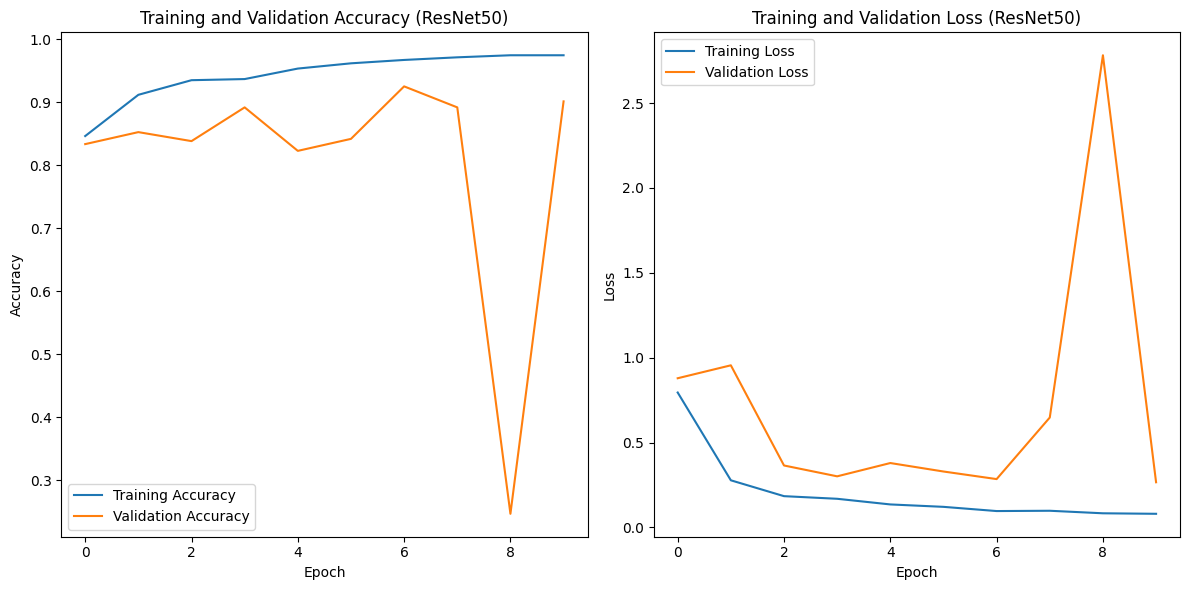

In [54]:
# Plotting the results of model training
plt.figure(figsize=(12, 6))

# Plot accuracy curve
plt.subplot(1, 2, 1)
plt.plot(resNet50_hist.history['binary_accuracy'], label='Training Accuracy')
plt.plot(resNet50_hist.history['val_binary_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy (ResNet50)')
plt.legend()

# Plot loss curve
plt.subplot(1, 2, 2)
plt.plot(resNet50_hist.history['loss'], label='Training Loss')
plt.plot(resNet50_hist.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (ResNet50)')
plt.legend()

plt.tight_layout()
plt.show()

<h1>Evaluation of the ResNet50 Model</h1>

In [55]:
# Evaluate the model on the validation set
resnet_val_loss, resnet_val_acc = resNetModel.evaluate(validation_dataset, verbose=2)
print(f'Validation accuracy: {resnet_val_acc}, Validation loss: {resnet_val_loss}')

# Evaluate the model on the test set
resnet_test_loss, resnet_test_acc = resNetModel.evaluate(X_test, y_test, verbose=2)
print(f'Test accuracy: {resnet_test_acc}, Test loss: {resnet_test_loss}')

27/27 - 27s - 984ms/step - binary_accuracy: 0.9060 - loss: 0.2619
Validation accuracy: 0.9059523940086365, Validation loss: 0.26192528009414673
27/27 - 25s - 939ms/step - binary_accuracy: 0.9595 - loss: 0.1115
Test accuracy: 0.9595237970352173, Test loss: 0.1115061566233635


In [57]:
# Evaluate the model on the test set and obtain predictions
test_predictionsResNet50 = resNetModel.predict(X_test, batch_size=batch_size, verbose=1)

# Convert probability scores to binary predictions (0 or 1)
testProbability_predictionsResNet50 = (test_predictionsResNet50 > 0.5).astype(int)

# Generate a classification report for precision, recall, and F1-score
testClassificationReport_ResNet50 = classification_report(y_test, testProbability_predictionsResNet50, output_dict=True)

# Print the test accuracy, precision, recall, and F1-score
print('Test Accuracy:', testClassificationReport_ResNet50['accuracy'])
print('Test Precision (Overall):', testClassificationReport_ResNet50['macro avg']['precision'])
print('Test Recall (Overall):', testClassificationReport_ResNet50['macro avg']['recall'])
print('Test F1 Score (Overall):', testClassificationReport_ResNet50['macro avg']['f1-score'])

27/27 ━━━━━━━━━━━━━━━━━━━━ 25s 919ms/step
Test Accuracy: 0.9595238095238096
Test Precision (Overall): 0.9689912826899127
Test Recall (Overall): 0.8842857142857143
Test F1 Score (Overall): 0.9201118881118882


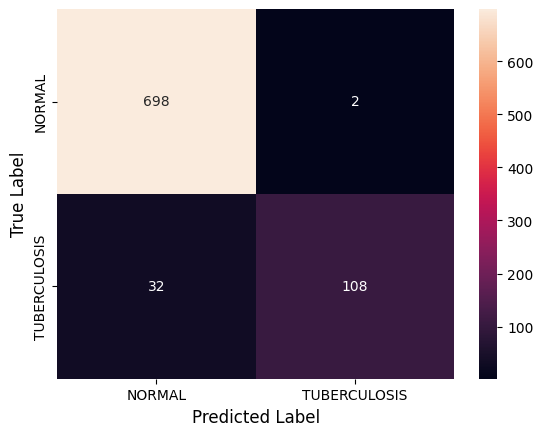

In [59]:
# Calculate the confusion matrix between true labels and predicted labels
confusionMatrix_ResNet50 = metrics.confusion_matrix(y_test, testProbability_predictionsResNet50)

# Heatmap of the confusion matrix with annotations
sns.heatmap(confusionMatrix_ResNet50, annot=True, fmt="d", xticklabels=['NORMAL', 'TUBERCULOSIS'], yticklabels=['NORMAL', 'TUBERCULOSIS'])

# Set the x-axis label
plt.xlabel("Predicted Label", fontsize=12)

# Set the y-axis label
plt.ylabel("True Label", fontsize=12)

# Display the heatmap
plt.show()

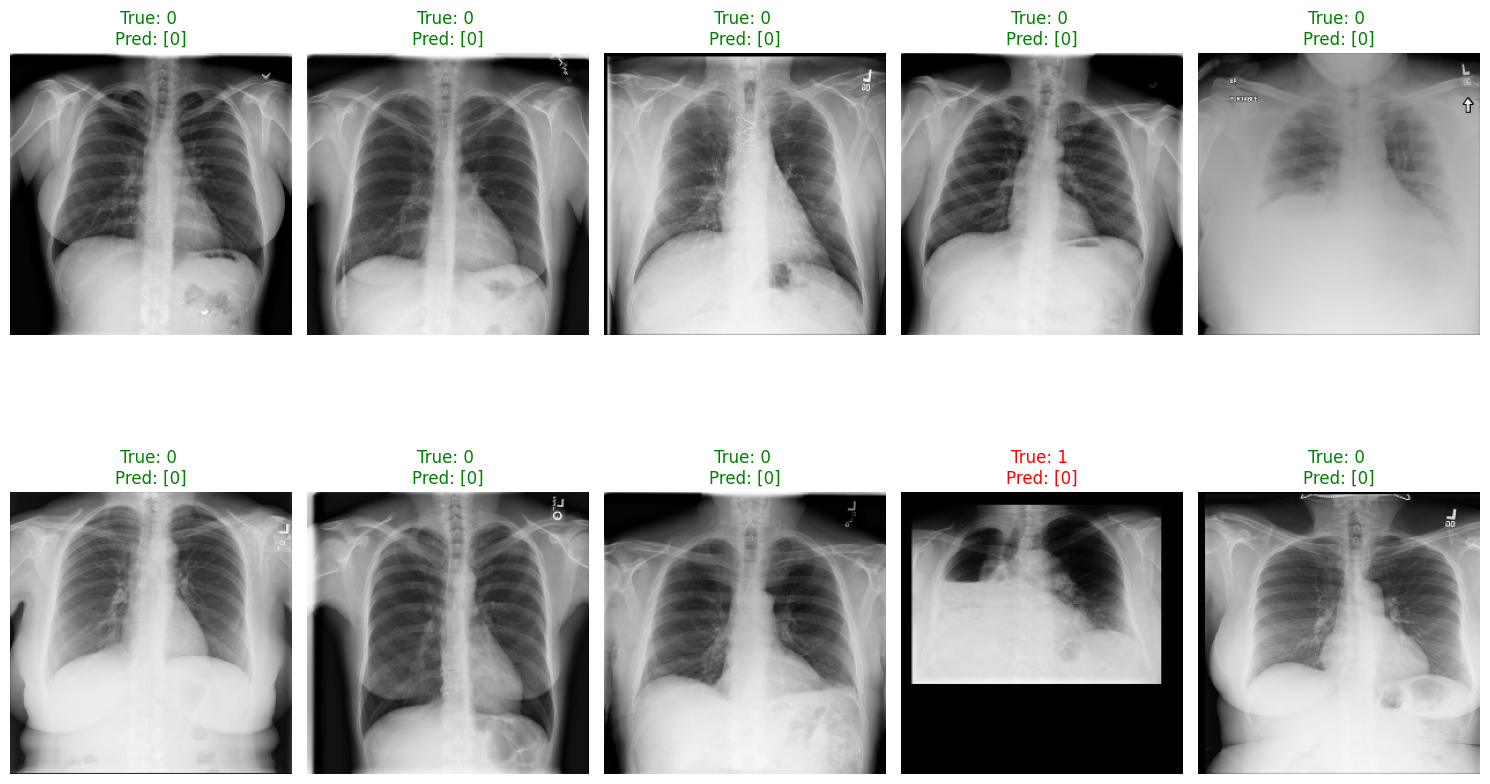

In [61]:
# Select a random sample of images to display
num_images_to_display = 10  # Number of images to display
indices = np.random.choice(len(X_test), num_images_to_display, replace=False)

plt.figure(figsize=(15, 10))

for i, idx in enumerate(indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_test[idx], cmap='gray')
    true_label = y_test[idx]
    predicted_label = testProbability_predictionsResNet50[idx]
    color = 'green' if true_label == predicted_label else 'red'
    plt.title(f"True: {true_label} \nPred: {predicted_label}", color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()

## Stacked Model of multiple EfficientNet models and MobileNetV2

In [62]:
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2, MobileNetV2

# Load EfficientNet and MobileNetV2 pre-trained models
baseMEfficientNetB0 = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(244, 244, 3))
baseMEfficientNetB1 = EfficientNetB1(weights='imagenet', include_top=False, input_shape=(244, 244, 3))
baseMEfficientNetB2 = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(244, 244, 3))
baseMMobileNetV2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(244, 244, 3))

# Freeze convolutional layers for all base models
for model in [baseMEfficientNetB0, baseMEfficientNetB1, baseMEfficientNetB2, baseMMobileNetV2]:
    for layer in model.layers:
        layer.trainable = False

# Define input tensor
input_tensor = Input(shape=(244, 244, 3))

# Extract features using global average pooling layer
efficientnetB0_out = baseMEfficientNetB0(input_tensor)
efficientnetB0_out = GlobalAveragePooling2D()(efficientnetB0_out)

efficientnetB1_out = baseMEfficientNetB1(input_tensor)
efficientnetB1_out = GlobalAveragePooling2D()(efficientnetB1_out)

efficientnetB2_out = baseMEfficientNetB2(input_tensor)
efficientnetB2_out = GlobalAveragePooling2D()(efficientnetB2_out)

mobilenetV2_out = baseMMobileNetV2(input_tensor)
mobilenetV2_out = GlobalAveragePooling2D()(mobilenetV2_out)

# Concatenate features from all models
concFeatures = Concatenate()([efficientnetB0_out, efficientnetB1_out, efficientnetB2_out, mobilenetV2_out])

# Add dense layers for final classification
output = Dense(512, activation='relu')(concFeatures)
output = Dense(1, activation='sigmoid')(output)

# Create the stacked model
stackedModel = Model(inputs=input_tensor, outputs=output, name='Stacked_Model')

# Compile the model
stackedModel.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['binary_accuracy'])

# Display a summary of the model architecture
stackedModel.summary()

Model: "Stacked_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)    │ (None, 244, 244, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ efficientnetb0 (Functional)   │ (None, 8, 8, 1280)        │       4,049,571 │ input_layer_4[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ efficientnetb1 (Functional)   │ (None, 8, 8, 1280)        │       6,575,239 │ input_layer_4[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ efficientnetb2 (Functional)   │ (None, 8, 8, 1408)        │       7,768,569 │ input_layer_4[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ mobilenetv2_1.00_224          │ (None, 8, 8, 1280)        │       2,257,984 │ input_layer_4[0][0]        │
│ (Functional)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_average_pooling2d      │ (None, 1280)              │               0 │ efficientnetb0[0][0]       │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_average_pooling2d_1    │ (None, 1280)              │               0 │ efficientnetb1[0][0]       │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_average_pooling2d_2    │ (None, 1408)              │               0 │ efficientnetb2[0][0]       │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_average_pooling2d_3    │ (None, 1280)              │               0 │ mobilenetv2_1.00_224[0][0] │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 5248)              │               0 │ global_average_pooling2d[… │
│                               │                           │                 │ global_average_pooling2d_… │
│                               │                           │                 │ global_average_pooling2d_… │
│                               │                           │                 │ global_average_pooling2d_… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_3 (Dense)               │ (None, 512)               │       2,687,488 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_4 (Dense)               │ (None, 1)                 │             513 │ dense_3[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 23,339,364 (89.03 MB)

 Trainable params: 2,688,001 (10.25 MB)

 Non-trainable params: 20,651,363 (78.78 MB)

In [63]:
# Train the model
stackedModel_hist = stackedModel.fit(
    train_dataset,                               # Training dataset
    batch_size=batch_size,                       # Batch size
    epochs=10,                                   # Number of training epochs
    validation_data=validation_dataset,          # Validation dataset
    callbacks=[early_stopping, reduceLR]         # Callbacks for early stopping and learning rate reduction
)

Epoch 1/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 363s 3s/step - binary_accuracy: 0.8950 - loss: 0.3185 - val_binary_accuracy: 0.9821 - val_loss: 0.0573 - learning_rate: 0.0010
Epoch 2/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 309s 3s/step - binary_accuracy: 0.9848 - loss: 0.0447 - val_binary_accuracy: 0.9905 - val_loss: 0.0355 - learning_rate: 0.0010
Epoch 3/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 317s 3s/step - binary_accuracy: 0.9831 - loss: 0.0461 - val_binary_accuracy: 0.9940 - val_loss: 0.0241 - learning_rate: 0.0010
Epoch 4/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 306s 3s/step - binary_accuracy: 0.9864 - loss: 0.0356 - val_binary_accuracy: 0.9940 - val_loss: 0.0188 - learning_rate: 0.0010
Epoch 5/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 305s 3s/step - binary_accuracy: 0.9914 - loss: 0.0314 - val_binary_accuracy: 0.9929 - val_loss: 0.0196 - learning_rate: 0.0010
Epoch 6/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - binary_accuracy: 0.9891 - loss: 0.0297
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.000500000023748725

<h1>Visualisation of the Stacked Model's training</h1>

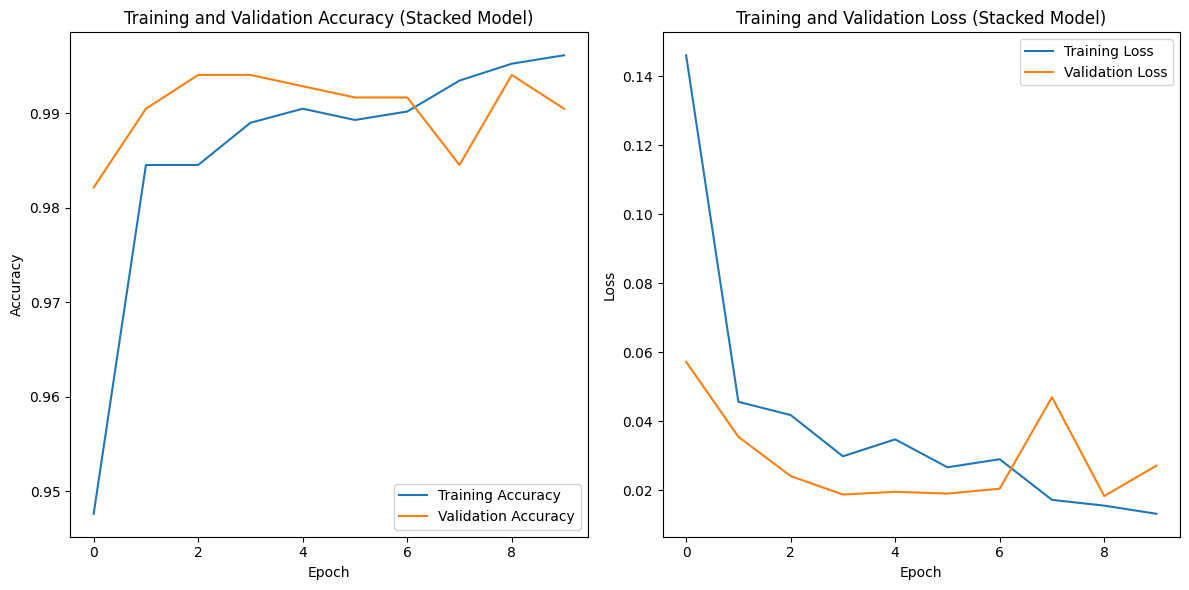

In [64]:
# Plotting the results of model training
plt.figure(figsize=(12, 6))

# Plot accuracy curve
plt.subplot(1, 2, 1)
plt.plot(stackedModel_hist.history['binary_accuracy'], label='Training Accuracy')
plt.plot(stackedModel_hist.history['val_binary_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy (Stacked Model)')
plt.legend()

# Plot loss curve
plt.subplot(1, 2, 2)
plt.plot(stackedModel_hist.history['loss'], label='Training Loss')
plt.plot(stackedModel_hist.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (Stacked Model)')
plt.legend()

plt.tight_layout()
plt.show()

<h1>Evaluation of the Stacked Model</h1>

In [65]:
# Evaluate the model on the validation set
stacked_val_loss, stacked_val_acc = stackedModel.evaluate(validation_dataset, verbose=2)
print(f'Validation accuracy: {stacked_val_acc}, Validation loss: {stacked_val_loss}')

# Evaluate the model on the test set
stacked_test_loss, stacked_test_acc = stackedModel.evaluate(X_test, y_test, verbose=2)
print(f'Test accuracy: {stacked_test_acc}, Test loss: {stacked_test_loss}')

27/27 - 63s - 2s/step - binary_accuracy: 0.9929 - loss: 0.0281
Validation accuracy: 0.9928571581840515, Validation loss: 0.028102057054638863
27/27 - 67s - 2s/step - binary_accuracy: 0.9940 - loss: 0.0271
Test accuracy: 0.9940476417541504, Test loss: 0.027139566838741302


In [67]:
# Evaluate the model on the test set and obtain predictions
test_predictionsStackedModel = stackedModel.predict(X_test, batch_size=batch_size, verbose=1)

# Convert probability scores to binary predictions (0 or 1)
testProbability_predictionsStackedModel = (test_predictionsStackedModel > 0.5).astype(int)

# Generate a classification report for precision, recall, and F1-score
testClassificationReport_StackedModel = classification_report(y_test, testProbability_predictionsStackedModel, output_dict=True)

# Print the test accuracy, precision, recall, and F1-score
print('Test Accuracy:', testClassificationReport_StackedModel['accuracy'])
print('Test Precision (Overall):', testClassificationReport_StackedModel['macro avg']['precision'])
print('Test Recall (Overall):', testClassificationReport_StackedModel['macro avg']['recall'])
print('Test F1 Score (Overall):', testClassificationReport_StackedModel['macro avg']['f1-score'])

27/27 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step
Test Accuracy: 0.9940476190476191
Test Precision (Overall): 0.9964539007092199
Test Recall (Overall): 0.9821428571428572
Test F1 Score (Overall): 0.9891297314784859


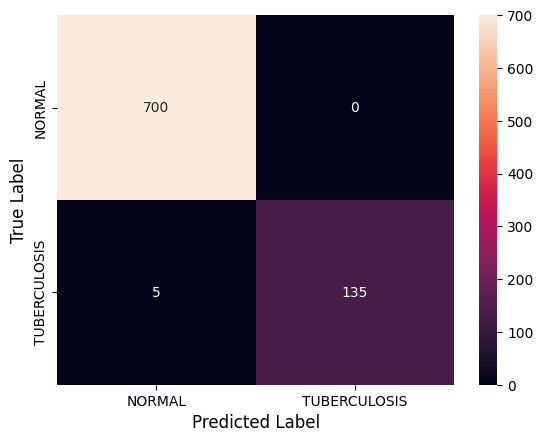

In [69]:
# Calculate the confusion matrix between true labels and predicted labels
confusionMatrix_StackedModel = metrics.confusion_matrix(y_test, testProbability_predictionsStackedModel)

# Heatmap of the confusion matrix with annotations
sns.heatmap(confusionMatrix_StackedModel, annot=True, fmt="d", xticklabels=['NORMAL', 'TUBERCULOSIS'], yticklabels=['NORMAL', 'TUBERCULOSIS'])

# Set the x-axis label
plt.xlabel("Predicted Label", fontsize=12)

# Set the y-axis label
plt.ylabel("True Label", fontsize=12)

# Display the heatmap
plt.show()

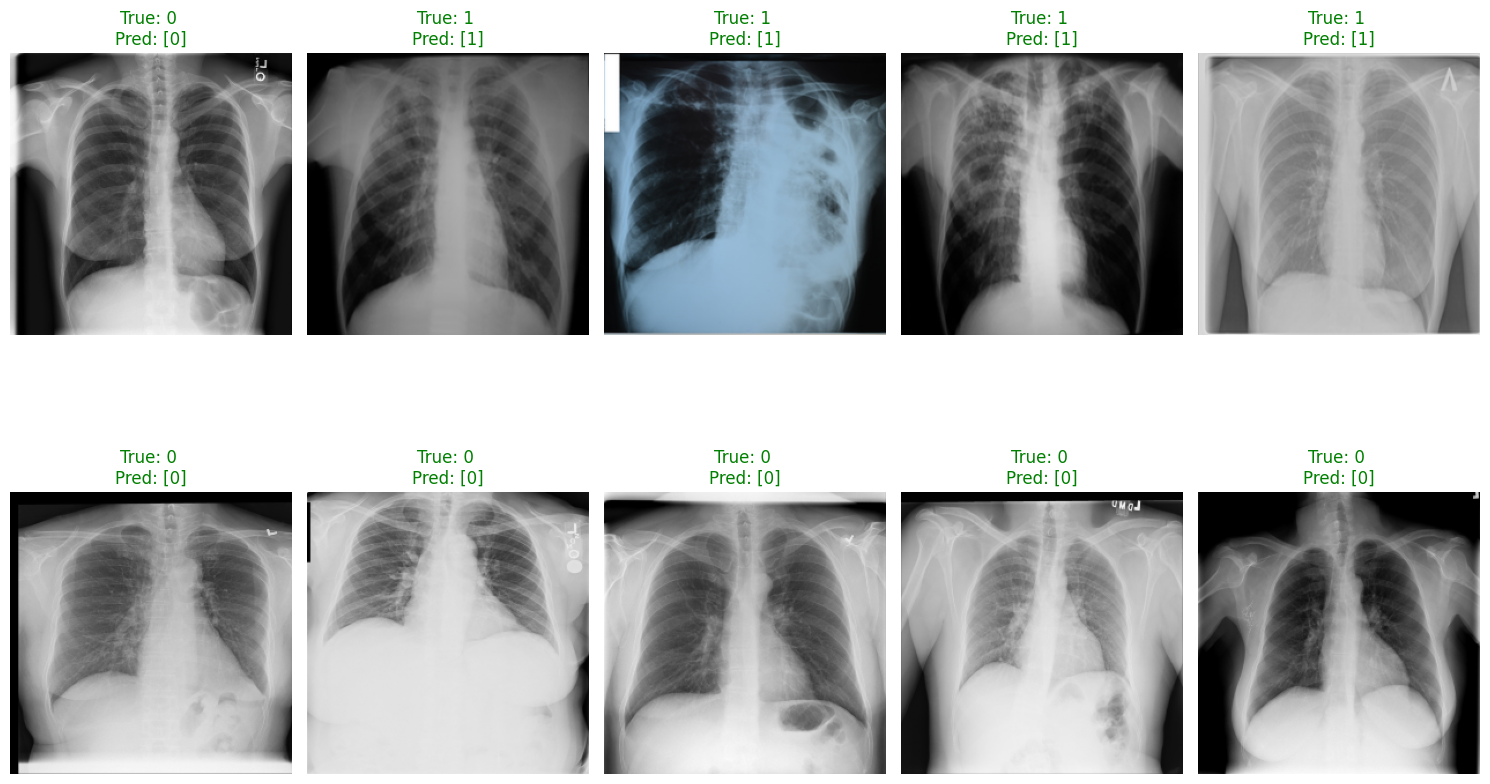

In [71]:
# Select a random sample of images to display
num_images_to_display = 10  # Number of images to display
indices = np.random.choice(len(X_test), num_images_to_display, replace=False)

plt.figure(figsize=(15, 10))

for i, idx in enumerate(indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_test[idx], cmap='gray')
    true_label = y_test[idx]
    predicted_label = testProbability_predictionsStackedModel[idx]
    color = 'green' if true_label == predicted_label else 'red'
    plt.title(f"True: {true_label} \nPred: {predicted_label}", color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()

## Basic Averaging Ensemble Model

In [73]:
# Define weights for each model
weights = [0.5, 0.5]

# Perform averaging of predictions
average_predictions = ( weights[0]*test_predictionsResNet50 + weights[1]*testProbability_predictionsStackedModel)

# Convert probability scores to binary predictions (0 or 1)
final_predictions = (average_predictions > 0.5).astype(int)

# Generate a classification report for precision, recall, and F1-score
testClassificationReport_AveragingModel = classification_report(y_test, final_predictions, output_dict=True)

# Print the test accuracy, precision, recall, and F1-score
print('Test Accuracy:', testClassificationReport_AveragingModel['accuracy'])
print('Test Precision (Overall):', testClassificationReport_AveragingModel['macro avg']['precision'])
print('Test Recall (Overall):', testClassificationReport_AveragingModel['macro avg']['recall'])
print('Test F1 Score (Overall):', testClassificationReport_AveragingModel['macro avg']['f1-score'])

Test Accuracy: 0.9940476190476191
Test Precision (Overall): 0.9964539007092199
Test Recall (Overall): 0.9821428571428572
Test F1 Score (Overall): 0.9891297314784859


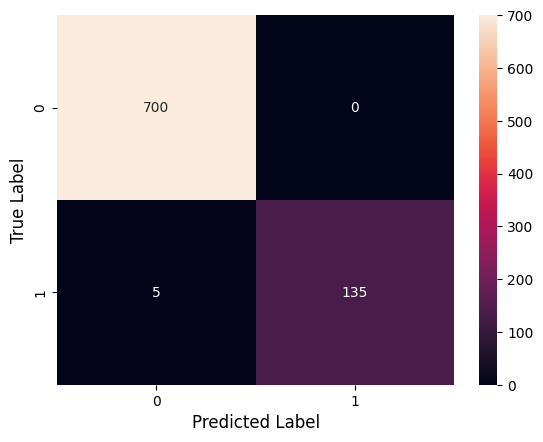

In [74]:
# Calculate the confusion matrix between true labels and predicted labels
confusionMatrix_AveragingModel = metrics.confusion_matrix(y_test, final_predictions)

# Heatmap of the confusion matrix with annotations
sns.heatmap(confusionMatrix_AveragingModel, annot=True, fmt="d")

# Set the x-axis label
plt.xlabel("Predicted Label", fontsize=12)

# Set the y-axis label
plt.ylabel("True Label", fontsize=12)

# Display the heatmap
plt.show()

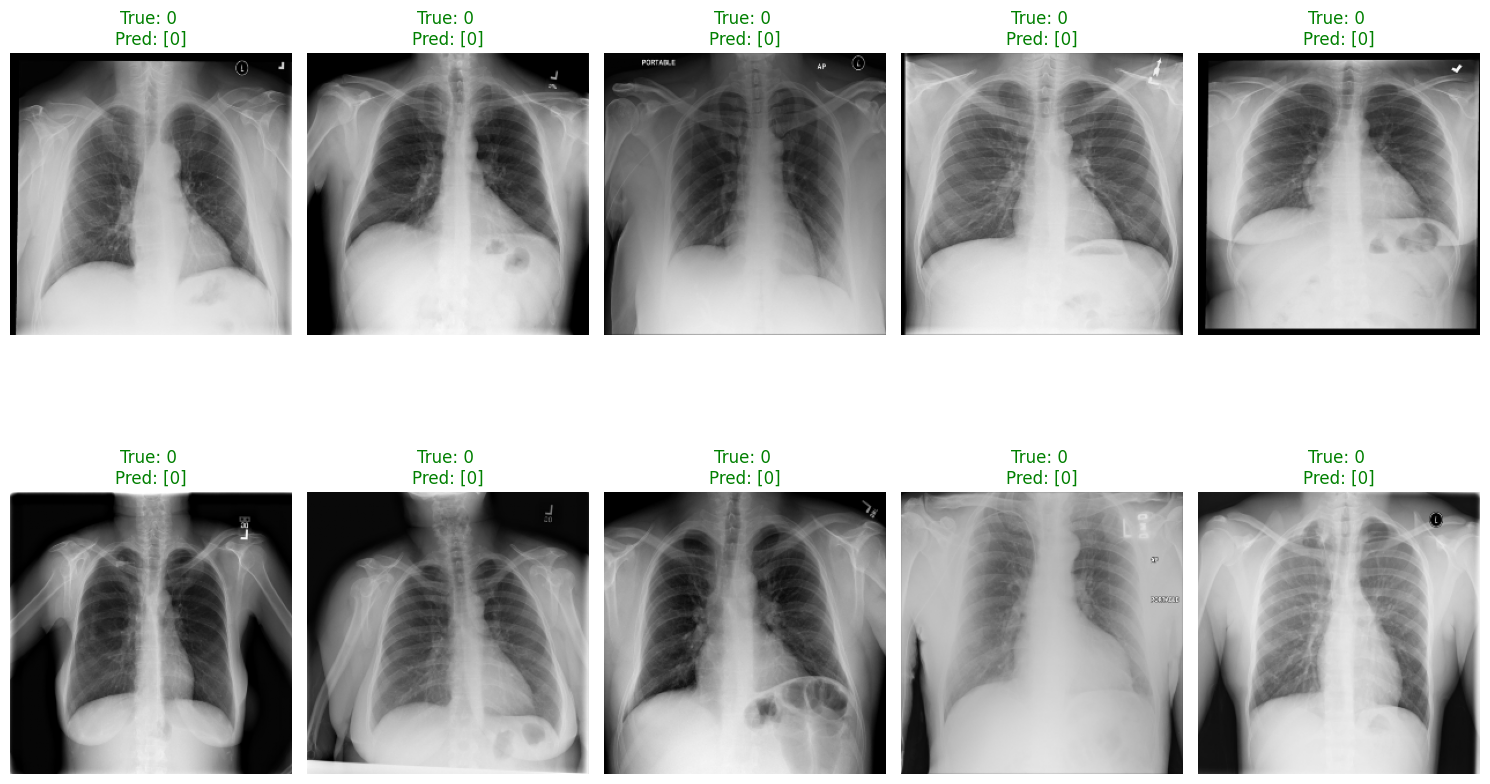

In [76]:
# Select a random sample of images to display
num_images_to_display = 10  # Number of images to display
indices = np.random.choice(len(X_test), num_images_to_display, replace=False)

plt.figure(figsize=(15, 10))

for i, idx in enumerate(indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_test[idx], cmap='gray')
    true_label = y_test[idx]
    predicted_label = final_predictions[idx]  # Use the final averaged prediction for display
    color = 'green' if true_label == predicted_label else 'red'
    plt.title(f"True: {true_label} \nPred: {predicted_label}", color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()

## Compare each model to the Averaging Ensembled Model

In [77]:
# Define a dictionary with model accuracy scores
accuracyScore_dict = {'ResNet50 Model': round(testClassificationReport_ResNet50['accuracy']*100,2), 
                'Stacked Transfer Learning Model': round(testClassificationReport_StackedModel['accuracy']*100,2), 
                'Averaging Ensemble Model': round(testClassificationReport_AveragingModel['accuracy']*100,2),
                'CNN Model': round(testClassificationReport_CNN['accuracy']*100,2)}

# Convert the dictionary into a Pandas Series
accuracyScore = pd.Series(accuracyScore_dict)

# Sort the models based on their accuracy scores and store the sorted order
order = accuracyScore.sort_values()

order

ResNet50 Model                     95.95
CNN Model                          97.50
Stacked Transfer Learning Model    99.40
Averaging Ensemble Model           99.40
dtype: float64

In [79]:
# Create dictionaries for each metric
accuracyScore_dict = {
    'CNN Model': round(testClassificationReport_CNN['accuracy']*100, 2), 
    'ResNet50 Model': round(testClassificationReport_ResNet50['accuracy']*100, 2),
    'Stacked Model': round(testClassificationReport_StackedModel['accuracy']*100, 2), 
    'Averaging Ensemble Model': round(testClassificationReport_AveragingModel['accuracy']*100, 2)
}

precisionScore_dict = {
    'CNN Model': round(testClassificationReport_CNN['macro avg']['precision']*100, 2), 
    'ResNet50 Model': round(testClassificationReport_ResNet50['macro avg']['precision']*100, 2),
    'Stacked Model': round(testClassificationReport_StackedModel['macro avg']['precision']*100, 2), 
    'Averaging Ensemble Model': round(testClassificationReport_AveragingModel['macro avg']['precision']*100, 2)
}

recallScore_dict = {
    'CNN Model': round(testClassificationReport_CNN['macro avg']['recall']*100, 2), 
    'ResNet50 Model': round(testClassificationReport_ResNet50['macro avg']['recall']*100, 2),
    'Stacked Model': round(testClassificationReport_StackedModel['macro avg']['recall']*100, 2), 
    'Averaging Ensemble Model': round(testClassificationReport_AveragingModel['macro avg']['recall']*100, 2)
}

f1Score_dict = {
    'CNN Model': round(testClassificationReport_CNN['macro avg']['f1-score']*100, 2), 
    'ResNet50 Model': round(testClassificationReport_ResNet50['macro avg']['f1-score']*100, 2),
    'Stacked Model': round(testClassificationReport_StackedModel['macro avg']['f1-score']*100, 2), 
    'Averaging Ensemble Model': round(testClassificationReport_AveragingModel['macro avg']['f1-score']*100, 2)
}

In [80]:
# Convert dictionaries into a DataFrame
scores_df = pd.DataFrame({
    'Model': list(accuracyScore_dict.keys()),
    'Accuracy': list(accuracyScore_dict.values()),
    'Precision': list(precisionScore_dict.values()),
    'Recall': list(recallScore_dict.values()),
    'F1 Score': list(f1Score_dict.values())
})

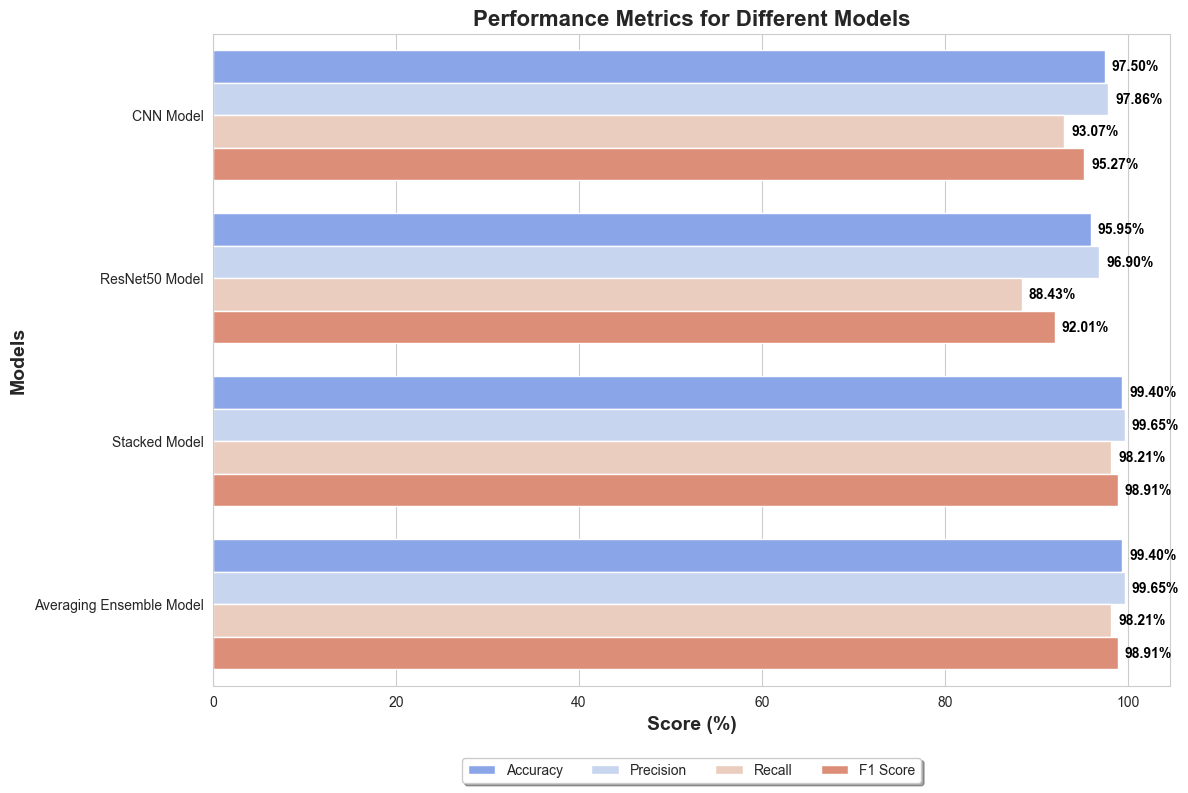

In [86]:
# Melt the DataFrame for easier plotting with seaborn
scores_df_melted = scores_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

# Set the style for the plots
sns.set_style('whitegrid')

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Create a bar plot
bar_plot = sns.barplot(x='Score', y='Model', hue='Metric', data=scores_df_melted, palette='coolwarm', orient='h')

# Set labels and title
plt.xlabel('Score (%)', fontsize=14, fontweight='bold')
plt.ylabel('Models', fontsize=14, fontweight='bold')
plt.title('Performance Metrics for Different Models', fontsize=16, fontweight='bold')

# Loop through the bars to annotate each with its value
for p in bar_plot.patches:
    # Format value only if it's greater than zero
    value = p.get_width()
    if value > 0:
        bar_plot.annotate(
            format(value, '.2f') + '%',  # Format to two decimal places and add '%'
            (value, p.get_y() + p.get_height() / 2),  # Annotation position
            ha='left', va='center',  # Horizontal and vertical alignment
            fontsize=10, color='black', weight='bold', xytext=(5, 0), textcoords='offset points'
        )

# Adjust layout to prevent overlapping and move the legend
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), shadow=True, ncol=4)  # Move legend below plot
plt.tight_layout()

# Show the plot
plt.show()